## Download Data

In [1]:
import os
import opendatasets as od


from pathlib import Path

In [2]:
def download_data(source: str) -> Path:
    """Downloads dataset from kaggle link."""
    data_path = Path(source.split("/")[4] + "/")
    print(data_path)

    # check if folder exists
    if data_path.is_dir():
        print(f"[INFO] {data_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {data_path} directory, creating one...")
        od.download("https://www.kaggle.com/competitions/dog-breed-identification/data")

    return data_path


In [3]:
download_data("https://www.kaggle.com/competitions/dog-breed-identification/data")


dog-breed-identification
[INFO] dog-breed-identification directory already exists, skipping download.


WindowsPath('dog-breed-identification')

## Explore Data

### Look at Top 10 breeds

In [4]:
import pandas as pd

In [5]:
df_breeds = pd.read_csv("dog-breed-identification\labels.csv")
df_breeds


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [6]:
# Count no of images for each breed
df_breeds_count = df_breeds.groupby(["breed"])["id"].count()
df_breeds_count


breed
affenpinscher                      80
afghan_hound                      116
african_hunting_dog                86
airedale                          107
american_staffordshire_terrier     74
                                 ... 
welsh_springer_spaniel             79
west_highland_white_terrier        81
whippet                            95
wire-haired_fox_terrier            82
yorkshire_terrier                  82
Name: id, Length: 120, dtype: int64

In [7]:
# Look at top 10 breeds with most images
df_breeds_count_top = df_breeds_count.sort_values(ascending=False)
df_breeds_count_top[:10]


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: id, dtype: int64

### View some images of the top 10 breeds

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

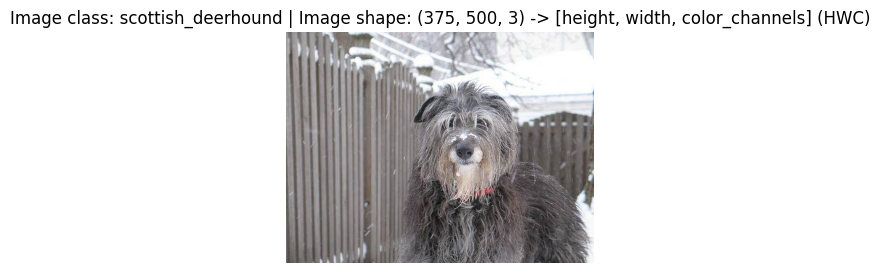

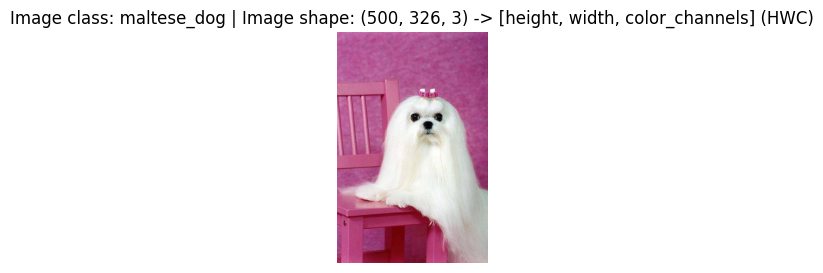

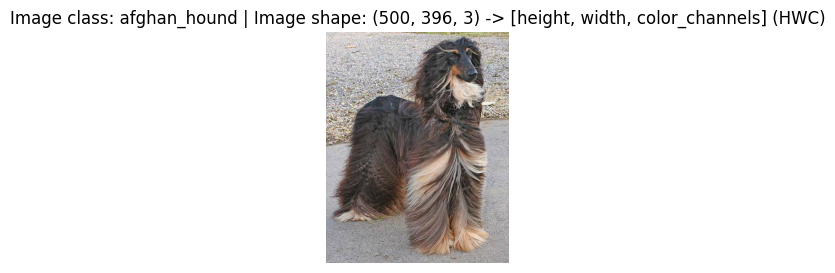

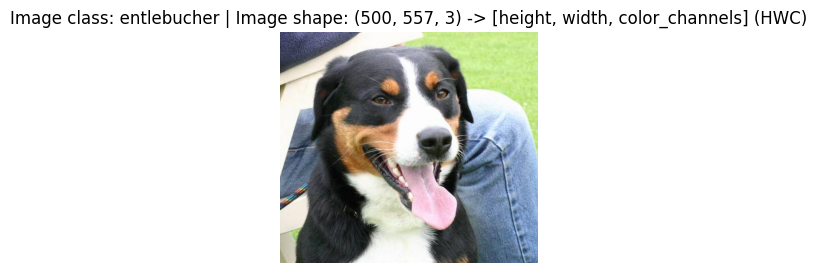

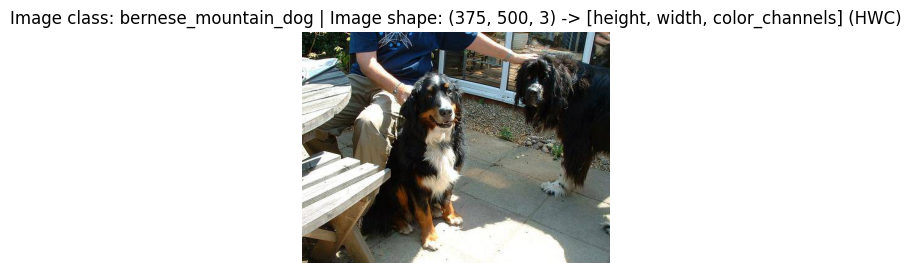

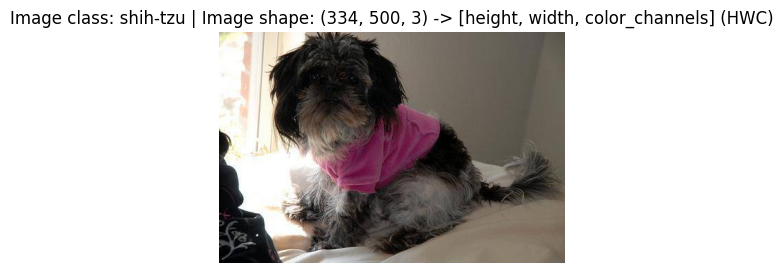

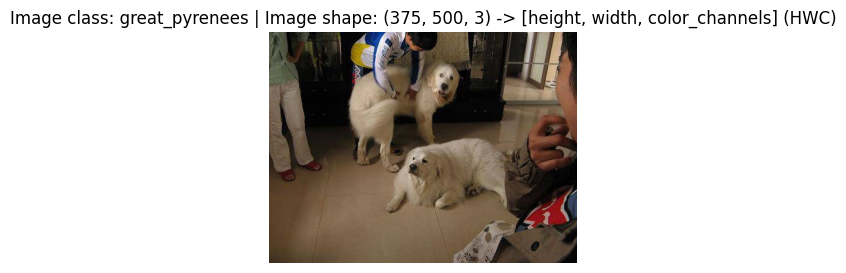

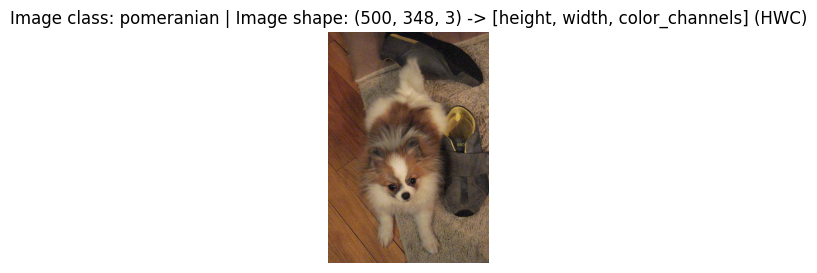

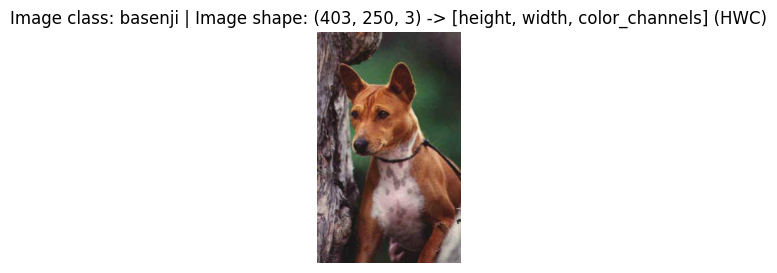

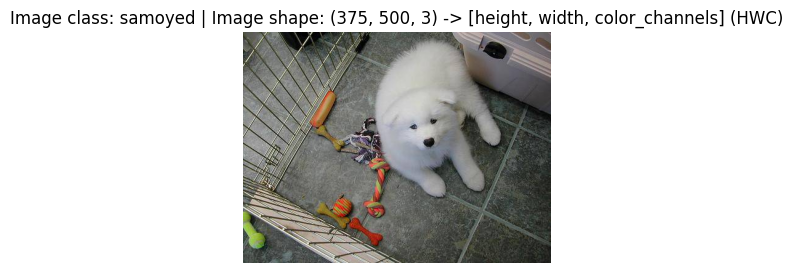

In [9]:
# plot one image for each breed in the top 10 from train set
for breed in df_breeds_count_top[:10].index:
    # get list of images for that breed
    df_selected_breed = df_breeds[df_breeds["breed"] == breed]
    image_list = df_selected_breed['id'].tolist()

    # select random image
    random_image = random.choice(image_list)

    # create image path
    image_path = "dog-breed-identification/train/" + random_image + ".jpg"
    image = Image.open(image_path)

    image_as_array = np.asarray(image)

    # Want 2 columns, 5 rows of images
    
    # Plot the image with matplotlib
    plt.figure(figsize=(5, 3))
    plt.imshow(image_as_array)
    plt.title(
        f"Image class: {breed} | Image shape: {image_as_array.shape} -> [height, width, color_channels] (HWC)"
    )
    plt.axis(False)

Noticed that there are some images where the dog covers only a small part of the image. May need bounding boxes to determine where exactly the dog is.